In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [55]:
df = pd.read_csv('./dataframe.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df = df[df.language != 'Dutch']
df = df[df.error_type != 'S']
df = df[df.error_type != 'SA']
df = df[df.error_type != 'SX']

In [56]:
def concat_dummies(df, dummies):
    for dummy in list(dummies):
        df[dummy] = dummies[dummy]

In [57]:
def merge_wrong_corrected_columns(df, wrong_column, corrected_column, prefix):
    wrong = pd.get_dummies(df[wrong_column], prefix=prefix)
    corrected = pd.get_dummies(df[corrected_column], prefix=prefix)
    for wc in list(set(wrong) - set(corrected)):
        corrected[wc] = 0
    for cc in list(set(corrected) - set(wrong)):
        wrong[cc] = 0
    wrong = wrong.where(wrong == 1, -3)
    wrong = wrong.where(wrong == -3, -1)
    corrected = corrected.where(corrected != 1, 4)
    merged = wrong.add(corrected)
    merged = merged.where(merged != 3, 0)
    return merged

In [58]:
merged_pos = merge_wrong_corrected_columns(df, 'error_pos', 'correct_pos', 'u')
merged_pos_2 = merge_wrong_corrected_columns(df, 'error_pos_2', 'correct_pos_2', 'b')
merged_pos_3 = merge_wrong_corrected_columns(df, 'error_pos_3', 'correct_pos_3', 't')
concat_dummies(df, merged_pos)
concat_dummies(df, merged_pos_2)
concat_dummies(df, merged_pos_3)

In [59]:
languages = {'language': {'French': 1, 'Spanish': 2, 'Catalan': 3, 'Portuguese': 4, 'Italian': 5, 'Polish': 6, 'Russian': 7,
'Greek': 8,'German': 9, 'Swedish': 10, 'Japanese': 11, 'Korean': 12, 'Turkish': 13, 'Chinese': 14, 'Thai':15}}
df.replace(languages, inplace=True)

In [60]:
y = df['error_type']

In [61]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
fit_data = x_train[list(merged_pos) + list(merged_pos_2) 
        + list(merged_pos_3) + ['language', 'error_length']]
test_data = x_test[list(merged_pos) + list(merged_pos_2) 
        + list(merged_pos_3) + ['language', 'error_length']]

In [62]:
clf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
clf.fit(fit_data, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [63]:
clf.score(test_data, y_test)

0.725183041035246

In [64]:
predictions = clf.predict(test_data)
values = list(y_test)
count = 0
dict_errors = {}
for i in range(len(predictions)):
    if predictions[i] != values[i]:
        tuple_err = predictions[i] + ' ' + values[i]
        if tuple_err in dict_errors:
            dict_errors[tuple_err] += 1
        else:
            dict_errors[tuple_err] = 1

for t in dict_errors.keys():
    if dict_errors[t] > 1:
        print(t, dict_errors[t])

RJ IJ 3
FN AGN 52
RV TV 43
UT UC 10
UV FV 2
RV IV 52
FN IJ 2
RD AGD 13
UT R 15
IV RV 8
FN CN 20
RV AGV 18
RT R 26
RV RJ 3
DN IN 2
RN RA 6
RN DN 34
TV MV 2
R W 8
DY RY 9
TV RV 56
RQ R 3
DJ RJ 7
UV RV 3
IJ IQ 3
UD RQ 3
UD RA 6
W R 28
TV DJ 2
RJ R 5
RJ DJ 45
TV W 5
TV X 5
RN IN 21
RV FV 9
AGN FN 45
W RY 3
U R 7
FN RN 17
RV R 12
DJ IJ 3
RY R 16
RY L 2
TV FV 13
AGV RV 9
FD R 2
R RA 4
RN AGN 7
R ID 10
RN R 12
RY W 2
RD RQ 7
RA AGA 25
IJ RJ 2
UT UV 3
RY DY 49
RC UC 2
RT UT 8
UC UY 5
CN FN 8
R U 10
UD R 5
FV UV 8
RD R 13
W U 11
UT UY 8
RN UN 8
RN CN 2
AGN IN 2
FV TV 9
ID W 5
RJ AGQ 2
RD UV 2
RD FD 12
RV RT 2
W ID 12
RJ CQ 5
RT RY 3
RV DV 12
TV UV 12
W UV 3
CN AGN 5
MA M 3
RQ RD 5
CN RN 3
RA UD 4
R AS 3
AGN DN 6
ID R 9
RT RJ 2
R RT 7
W X 4
RC R 8
RY RC 3
RN FN 2
RY RT 5
U W 5
RA UA 4
RY FY 11
TV R 10
RT L 5
W TV 6
W UY 2
UT W 4
R RQ 3
W AS 10
UD UQ 8
UA R 5
TV IV 7
RT W 3
AGN CN 11
FN DN 5
RV UJ 2
RV UV 16
AGN RN 10
R AGQ 2
TV AS 4
FD RD 3
RN ID 3
U UY 2
IV RJ 2
UT RY 4
R RC 8
RN W 2
RD UD 5
UT

In [65]:
importances = pd.DataFrame({'feature': list(fit_data), 'feature_importance': clf.feature_importances_})
importances = importances.set_index('feature')

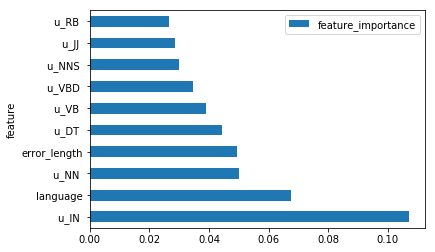

In [66]:
importances = importances.sort_values(by=['feature_importance'], ascending=False)
top_10 = importances[:10]
top_10.plot(kind='barh')